In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import requests
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
response = requests.get(url)
with open("course_lead_scoring.csv", "wb") as f:
    f.write(response.content)
# Load the dataset
df = pd.read_csv('course_lead_scoring.csv')
# Check the first few rows to understand the data
print(df.head())
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)
# Handle missing values as instructed
# For categorical features, replace with 'NA'
# For numerical features, replace with 0.0
# First, identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns
# Replace missing values
for col in categorical_columns:
    df[col] = df[col].fillna('NA')
for col in numerical_columns:
    df[col] = df[col].fillna(0.0)

    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  
Missing values per column:
lead_source                 128
industry                    134
nu

In [2]:
# Find the mode (most frequent value) for the 'industry' column
industry_mode = df['industry'].mode()[0]
print(f"Most frequent value in 'industry' column: {industry_mode}")

Most frequent value in 'industry' column: retail


Correlation Matrix:
                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   
converted                                 0.435914       0.053131   

                          interaction_count  lead_score  converted  
number_of_courses_viewed          -0.023565   -0.004879   0.435914  
annual_income                      0.027036    0.015610   0.053131  
interaction_count                  1.000000    0.009888   0.374573  
lead_score                         0.009888    1.000000   0.193673  
converted                          0.374573    0.193673   1.000000  


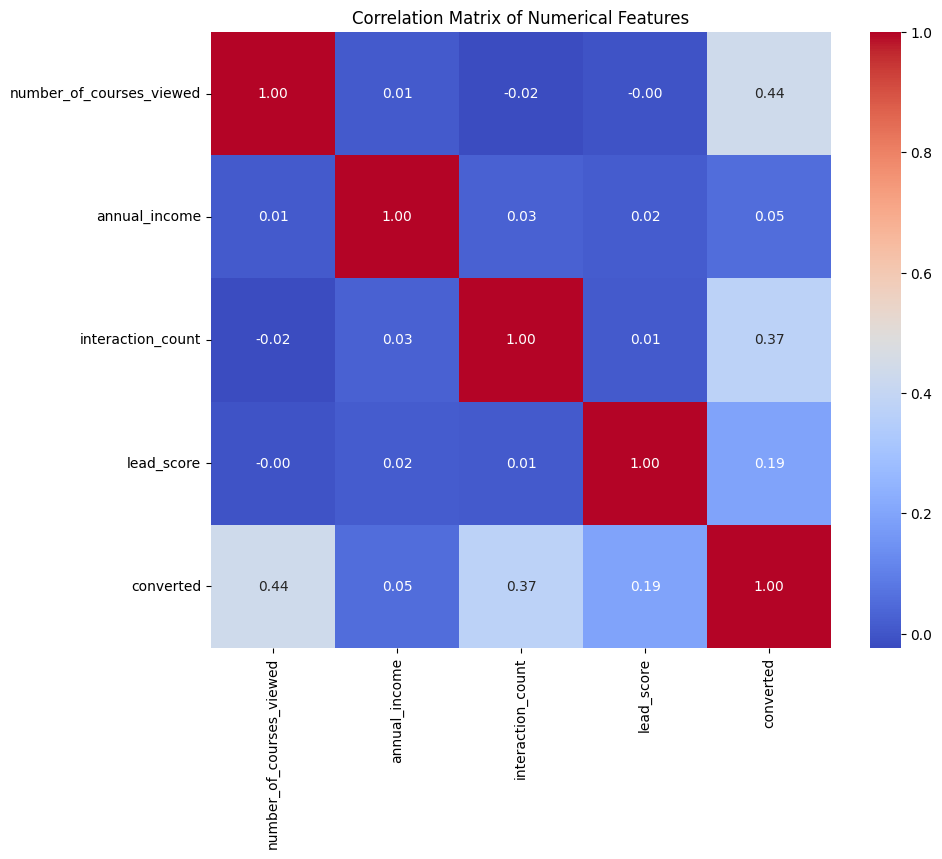

Correlation between interaction_count and lead_score: 0.0099
Correlation between number_of_courses_viewed and lead_score: -0.0049
Correlation between number_of_courses_viewed and interaction_count: -0.0236
Correlation between annual_income and interaction_count: 0.0270


In [3]:
# Create correlation matrix for numerical features
correlation_matrix = df[numerical_columns].corr()
print("Correlation Matrix:")
print(correlation_matrix)
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()
# Check specific pairs mentioned in the question
pairs = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]
for pair in pairs:
    corr = correlation_matrix.loc[pair[0], pair[1]]
    print(f"Correlation between {pair[0]} and {pair[1]}: {corr:.4f}")

In [4]:
# Separate target variable
X = df.drop('converted', axis=1)
y = df['converted']
# Split the data into train, validation, and test sets (60%/20%/20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 876
Validation set size: 293
Test set size: 293


In [5]:
# Identify categorical columns in the training set
categorical_columns = X_train.select_dtypes(include=['object']).columns
# Calculate mutual information score for each categorical variable
mi_scores = {}
for col in categorical_columns:
    mi_score = mutual_info_classif(
        pd.get_dummies(X_train[col], drop_first=True),  # One-hot encode the categorical variable
        y_train,
        random_state=42
    )[0]  # Take the first (and only) score
    mi_scores[col] = round(mi_score, 2)
print("Mutual Information Scores:")
for col, score in mi_scores.items():
    print(f"{col}: {score}")
# Find the categorical variable with the highest mutual information score
highest_mi_col = max(mi_scores, key=mi_scores.get)
print(f"\nCategorical variable with highest mutual information score: {highest_mi_col} with score {mi_scores[highest_mi_col]}")

Mutual Information Scores:
lead_source: 0.0
industry: 0.02
employment_status: 0.0
location: 0.0

Categorical variable with highest mutual information score: industry with score 0.02


In [10]:
# Prepare the data with one-hot encoding for categorical variables
def prepare_data(X):
    X_processed = X.copy()
    
    # One-hot encode categorical variables
    for col in categorical_columns:
        dummies = pd.get_dummies(X_processed[col], prefix=col, drop_first=False)
        X_processed = pd.concat([X_processed, dummies], axis=1)
        X_processed.drop(col, axis=1, inplace=True)
    
    return X_processed

X_train_processed = prepare_data(X_train)
X_val_processed = prepare_data(X_val)
# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_processed, y_train)
# Calculate accuracy on validation set
y_val_pred = model.predict(X_val_processed)
accuracy = round(accuracy_score(y_val, y_val_pred), 2)
print(f"Validation accuracy: {accuracy}")

Validation accuracy: 0.7


In [11]:
# Get the original accuracy (without rounding)
original_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Original accuracy: {original_accuracy}")
# Function to train model without a specific feature and get accuracy
def get_accuracy_without_feature(feature_to_exclude):
    # Create a list of features excluding the one we want to remove
    features_to_use = [col for col in X_train_processed.columns if not col.startswith(feature_to_exclude)]
    
    # Train model without the feature
    model_without_feature = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_without_feature.fit(X_train_processed[features_to_use], y_train)
    
    # Calculate accuracy
    y_val_pred_without_feature = model_without_feature.predict(X_val_processed[features_to_use])
    accuracy_without_feature = accuracy_score(y_val, y_val_pred_without_feature)
    
    return accuracy_without_feature

# Check the features mentioned in the question
features_to_check = ['industry', 'employment_status', 'lead_score']
accuracy_differences = {}

for feature in features_to_check:
    accuracy_without_feature = get_accuracy_without_feature(feature)
    difference = original_accuracy - accuracy_without_feature
    accuracy_differences[feature] = difference
    print(f"Accuracy without {feature}: {accuracy_without_feature}, Difference: {difference}")
# Find the feature with the smallest difference
smallest_diff_feature = min(accuracy_differences, key=lambda k: abs(accuracy_differences[k]))
print(f"\nFeature with smallest difference: {smallest_diff_feature} with difference {accuracy_differences[smallest_diff_feature]}")

Original accuracy: 0.6996587030716723
Accuracy without industry: 0.6996587030716723, Difference: 0.0
Accuracy without employment_status: 0.6962457337883959, Difference: 0.0034129692832763903
Accuracy without lead_score: 0.7064846416382252, Difference: -0.0068259385665528916

Feature with smallest difference: industry with difference 0.0


In [12]:
# Try different values of C
c_values = [0.01, 0.1, 1, 10, 100]
accuracy_scores = {}
for c in c_values:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train_processed, y_train)
    
    y_val_pred = model.predict(X_val_processed)
    accuracy = round(accuracy_score(y_val, y_val_pred), 3)
    accuracy_scores[c] = accuracy
    print(f"C={c}, Validation accuracy: {accuracy}")
# Find the C with the best accuracy
best_c = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nBest C value: {best_c} with accuracy {accuracy_scores[best_c]}")
# If there are multiple C values with the same best accuracy, find the smallest one
best_accuracy = accuracy_scores[best_c]
best_c_values = [c for c, acc in accuracy_scores.items() if acc == best_accuracy]
smallest_best_c = min(best_c_values)
print(f"Smallest C value with best accuracy: {smallest_best_c}")

C=0.01, Validation accuracy: 0.7
C=0.1, Validation accuracy: 0.7
C=1, Validation accuracy: 0.7
C=10, Validation accuracy: 0.7
C=100, Validation accuracy: 0.7

Best C value: 0.01 with accuracy 0.7
Smallest C value with best accuracy: 0.01
